In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn joblib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib


In [3]:
churn_data = pd.read_excel("churn_data_view.xlsx")


In [4]:
print(churn_data.head())

  Customer_ID  Gender  Age Married          State  Number of Referrals  \
0   74594-TEL    Male   24      No      Telangana                    9   
1   74656-ASS  Female   74      No          Assam                   11   
2   74664-UTT  Female   44     Yes  Uttar Pradesh                    0   
3   74667-TAM  Female   45     Yes     Tamil Nadu                   14   
4   74668-MAH    Male   24     Yes    Maharashtra                   10   

   Tenure_in_Months Value_Deal Phone_Service Multiple_Lines  ...  \
0                12        NaN           Yes            Yes  ...   
1                24        NaN           Yes            Yes  ...   
2                23        NaN           Yes             No  ...   
3                31     Deal 1           Yes             No  ...   
4                 9        NaN           Yes            Yes  ...   

    Payment_Method Monthly_Charge Total_Charges Total_Refunds  \
0     Mailed Check      84.650002     84.650002          0.00   
1  Bank Withdraw

In [5]:
churn_data = churn_data.drop(['Customer_ID', 'Churn_Category', 'Churn_Reason'], axis=1)

In [10]:
columns_to_encode = [
    'Gender', 'Married', 'State', 'Value_Deal', 'Phone_Service', 'Multiple_Lines',
    'Internet_Service', 'Internet_Type', 'Online_Security', 'Online_Backup',
    'Device_Protection_Plan', 'Premium_Support', 'Streaming_TV', 'Streaming_Movies',
    'Streaming_Music', 'Unlimited_Data', 'Contract', 'Paperless_Billing',
    'Payment_Method'
]


In [12]:
# Encode categorical variables except the target variable
label_encoders = {}
for column in columns_to_encode:
    label_encoders[column] = LabelEncoder()
    churn_data[column] = label_encoders[column].fit_transform(churn_data[column])


In [13]:
# Manually encode the target variable 'Customer_Status'
churn_data['Customer_Status'] = churn_data['Customer_Status'].map({'Stayed': 0, 'Churned': 1})

In [14]:
# Split data into features and target
X = churn_data.drop('Customer_Status', axis=1)
y = churn_data['Customer_Status']


In [15]:
# Split data into training and testing sets
# test_size = 0.2 means 20% of data will be kept for testing purpose
# remaining 80% of data will be used for training the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Train Random Forest Model

In [16]:
# Initialize the Random Forest Classifier
# n_estimators = 100 means 100 decision trees have been created
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

### Evaluate Model

Confusion Matrix:
[[811  51]
 [114 226]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       862
           1       0.82      0.66      0.73       340

    accuracy                           0.86      1202
   macro avg       0.85      0.80      0.82      1202
weighted avg       0.86      0.86      0.86      1202



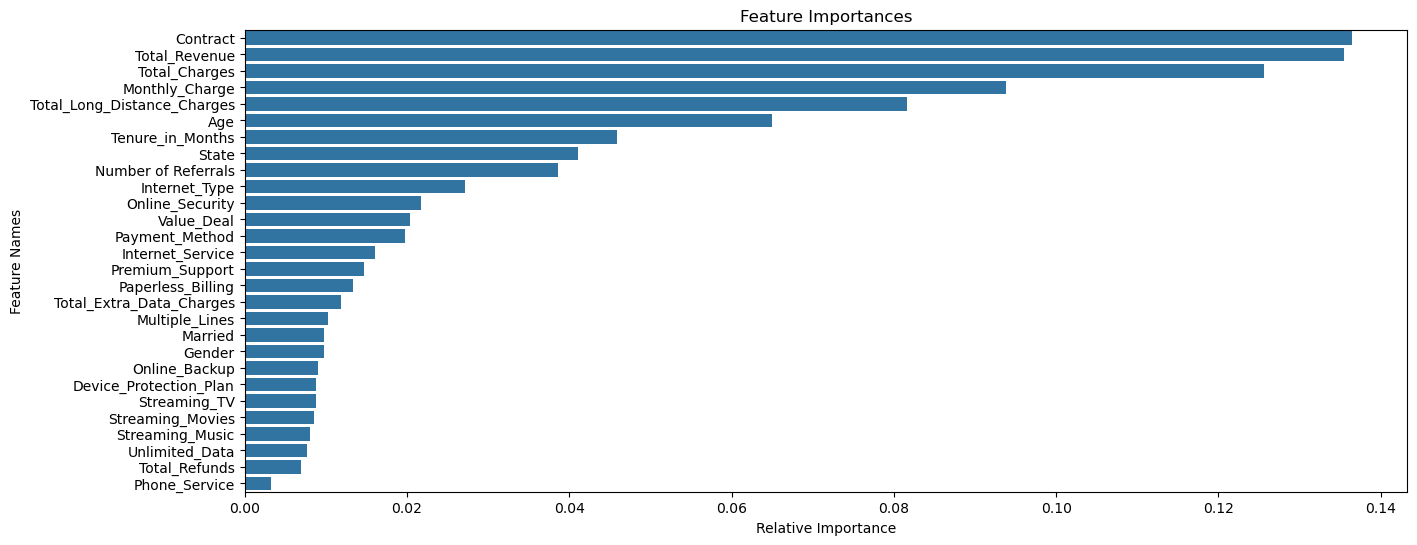

In [17]:
# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature Selection using Feature Importance
# (checking how imp each of the indep. features are) 
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(15, 6))
sns.barplot(x=importances[indices], y=X.columns[indices])
plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.ylabel('Feature Names')
plt.show()


In [18]:
# Confusion Matrix intuition : helps to visualize performance of the model
# rows = actual class (no,yes) , columns = predicted class (no,yes)
# no = 0 = not churned 
# yes = 1 = churned
# 811 = True -ve : means the model correctly predicted that 811 customers would not churn
# 226 = True +ve : model correctly predicted that 226 customers will churn
# 51 = False +ve : model incorrectly predicted that 51 cust. would churn
# 114 = False -ve : model incorrectly predicted that 114 cust. would not churn



##### Precision : measures accuracy of the positive predictions made by the model
##### Recall : measures the models ability to correctly identify all positive instances
##### F1 Score : Harmonic mean of Precision and Recall
##### Support : no. of instances(cases) in data

#### "precision , recall , f1 score for class 0 (not churned) is higher than class 1 , meaning model is good at predicting customers who will not churn"

## Use Model for Prediction on New Data

In [20]:
join_data = pd.read_excel("join_data_view.xlsx")

In [22]:
join_data_og = join_data.copy()

In [23]:
# Retain the Customer_ID column
customer_ids = join_data['Customer_ID']

# Drop columns that won't be used for prediction in the encoded DataFrame
join_data = join_data.drop(['Customer_ID', 'Customer_Status', 'Churn_Category', 'Churn_Reason'], axis=1)

# Encode categorical variables using the saved label encoders
for column in join_data.select_dtypes(include=['object']).columns:
    join_data[column] = label_encoders[column].transform(join_data[column])


In [24]:
# Make predictions
new_predictions = rf_model.predict(join_data)


In [25]:
# Add predictions to the original DataFrame
join_data_og['Customer_Status_Predicted'] = new_predictions

# Filter the DataFrame to include only records predicted as "Churned"
join_data_og = join_data_og[join_data_og['Customer_Status_Predicted'] == 1]


In [26]:
#Save the results
join_data_og.to_csv("Predictions.csv",index=False)